In [1]:
import os
from PIL import Image

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


label_dict = {"cats": 0, "dogs": 1}
class_dict = {0: "cats", 1: "dogs"}
N = 2

class MyDataset(Dataset):
    def __init__(self, _data_dir, _transform, _loader):
        self.labels = [_label for _label in os.listdir(_data_dir)]
        _file_path_label_list = [(os.path.join(_data_dir, _label, _img_fn), _label)
                                 for _label in os.listdir(_data_dir)
                                 for _img_fn in os.listdir(os.path.join(_data_dir, _label))
                                 if not os.path.isdir(os.path.join(_data_dir, _label, _img_fn))]

        self.data = [(_loader(_fp), label_dict[_label]) for _fp, _label in _file_path_label_list]
        self.transform = _transform

    def __getitem__(self, item):
        _img, _label = self.data[item]
        _img = self.transform(_img)
        return _img, _label

    def __len__(self):
        return len(self.data)


def load_data():
    print('data processing...')
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
    ])
    data_dir = "data/training_data/"
    train_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))
    test_dataset = MyDataset(data_dir, transform, _loader=lambda _path: Image.open(_path).convert('RGB'))

    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = torch.utils.data.random_split(train_dataset, [train_size, validate_size])

    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader




In [2]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from classify.data_process import load_data
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from classify.decorator import metric_time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)

class cnn(nn.Module):
    def __init__(self, in_channels=3):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=16,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc1 = nn.Linear(3 * 3 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        self.out = nn.Linear(10, N)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out(x))
        x = F.log_softmax(x, dim=1)
        return x


def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())

    return np.mean(val_loss)


@metric_time
def train():
    writer = SummaryWriter("log/")
    train_data_loader, val_data_loader, _ = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = 5
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, val_data_loader)
        writer.add_scalar("val_loss", val_loss, epoch)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    torch.save(best_model.state_dict(), "model/cnn.pkl")


@metric_time
def test():
    _, _, test_dataset = load_data()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn.pkl"), False)
    total = 0
    current = 0
    model.eval()
    for (data, target) in test_dataset:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted = torch.max(outputs.data, 1)[1].data
        total += target.size(0)
        current += (predicted == target).sum()

    print('Accuracy:%d%%' % (100 * current / total))

In [3]:
train()

data processing...


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

train...


  3%|##7                                                                                | 1/30 [00:05<02:41,  5.57s/it]

Epoch 000 train_loss 0.68973 val_loss 0.70853


  7%|#####5                                                                             | 2/30 [00:10<02:33,  5.48s/it]

Epoch 001 train_loss 0.66871 val_loss 0.73119


 10%|########3                                                                          | 3/30 [00:16<02:26,  5.43s/it]

Epoch 002 train_loss 0.64509 val_loss 0.71693


 13%|###########                                                                        | 4/30 [00:21<02:21,  5.46s/it]

Epoch 003 train_loss 0.61758 val_loss 0.60695


 17%|#############8                                                                     | 5/30 [00:27<02:17,  5.49s/it]

Epoch 004 train_loss 0.59542 val_loss 0.59591


 20%|################6                                                                  | 6/30 [00:32<02:12,  5.53s/it]

Epoch 005 train_loss 0.57308 val_loss 0.62047


 23%|###################3                                                               | 7/30 [00:38<02:07,  5.54s/it]

Epoch 006 train_loss 0.54340 val_loss 0.55288


 27%|######################1                                                            | 8/30 [00:43<02:00,  5.48s/it]

Epoch 007 train_loss 0.54437 val_loss 0.58731


 30%|########################9                                                          | 9/30 [00:49<01:54,  5.45s/it]

Epoch 008 train_loss 0.52740 val_loss 0.58669


 33%|###########################3                                                      | 10/30 [00:54<01:50,  5.50s/it]

Epoch 009 train_loss 0.51883 val_loss 0.55949


 37%|##############################                                                    | 11/30 [01:00<01:46,  5.59s/it]

Epoch 010 train_loss 0.50200 val_loss 0.67776


 40%|################################8                                                 | 12/30 [01:06<01:40,  5.56s/it]

Epoch 011 train_loss 0.49872 val_loss 0.55188


 43%|###################################5                                              | 13/30 [01:11<01:34,  5.59s/it]

Epoch 012 train_loss 0.49031 val_loss 0.56868


 47%|######################################2                                           | 14/30 [01:17<01:28,  5.54s/it]

Epoch 013 train_loss 0.46778 val_loss 0.57934


 50%|#########################################                                         | 15/30 [01:22<01:23,  5.53s/it]

Epoch 014 train_loss 0.45396 val_loss 0.56881


 53%|###########################################7                                      | 16/30 [01:28<01:16,  5.49s/it]

Epoch 015 train_loss 0.47912 val_loss 0.69252


 57%|##############################################4                                   | 17/30 [01:33<01:10,  5.46s/it]

Epoch 016 train_loss 0.46222 val_loss 0.59235


 60%|#################################################1                                | 18/30 [01:38<01:05,  5.45s/it]

Epoch 017 train_loss 0.44639 val_loss 0.50977


 63%|###################################################9                              | 19/30 [01:44<00:59,  5.45s/it]

Epoch 018 train_loss 0.43086 val_loss 0.62359


 67%|######################################################6                           | 20/30 [01:49<00:54,  5.43s/it]

Epoch 019 train_loss 0.43604 val_loss 0.55463


 70%|#########################################################4                        | 21/30 [01:55<00:49,  5.46s/it]

Epoch 020 train_loss 0.43151 val_loss 0.53987


 73%|############################################################1                     | 22/30 [02:00<00:43,  5.48s/it]

Epoch 021 train_loss 0.42098 val_loss 0.54146


 77%|##############################################################8                   | 23/30 [02:06<00:38,  5.52s/it]

Epoch 022 train_loss 0.40759 val_loss 0.54677


 80%|#################################################################6                | 24/30 [02:12<00:33,  5.63s/it]

Epoch 023 train_loss 0.40789 val_loss 0.51616


 83%|####################################################################3             | 25/30 [02:17<00:27,  5.60s/it]

Epoch 024 train_loss 0.39947 val_loss 0.53852


 87%|#######################################################################           | 26/30 [02:23<00:22,  5.59s/it]

Epoch 025 train_loss 0.40737 val_loss 0.53960


 90%|#########################################################################8        | 27/30 [02:29<00:17,  5.67s/it]

Epoch 026 train_loss 0.39733 val_loss 0.52624


 93%|############################################################################5     | 28/30 [02:34<00:11,  5.63s/it]

Epoch 027 train_loss 0.40244 val_loss 0.67255


 97%|###############################################################################2  | 29/30 [02:40<00:05,  5.60s/it]

Epoch 028 train_loss 0.40157 val_loss 0.55255


100%|##################################################################################| 30/30 [02:45<00:00,  5.53s/it]
2024-11-14 11:01:46.511 | DEBUG    | classify.decorator:wrapper:13 - train运行时间: 169.54288411140442 s


Epoch 029 train_loss 0.38560 val_loss 0.55742


In [6]:
nn.Softmax

torch.nn.modules.activation.Softmax

In [11]:
test()

data processing...


<ipython-input-8-5d7c573361b5>:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)
2024-11-14 09:25:31.156 | DEBUG  

Accuracy:85%


In [7]:
pip install tensorboard loguru -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple
Note: you may need to restart the kernel to use updated packages.


# 测试猫狗二分类模型

In [21]:
import unittest
from PIL import Image

import torch
from matplotlib import pyplot as plt
from torchvision import transforms

from classify.cnn import cnn
from classify.data_process import class_dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = cnn().to(device)
model.load_state_dict(torch.load("model/cnn.pkl"), False)
model.eval()

_img_path = "data/testing_data/dogs/dog.1031.jpg"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalization
])
img = Image.open(_img_path).convert('RGB')
# 模拟批样本
img_transform = transform(img).unsqueeze(0)

output = model(img_transform)

output

<ipython-input-21-34fdc36d7b53>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model/cnn.pkl"), False)


tensor([[-0.9589, -0.4834]], grad_fn=<LogSoftmaxBackward0>)

In [5]:
np.log(0.5)

-0.6931471805599453

In [31]:
pred = class_dict[torch.max(output.data, 1)[1].data.item()]
print(pred)

dogs


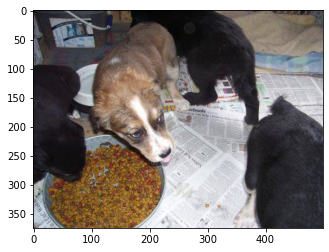

In [32]:
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
tensorboard --logdir_spec=jupyterlab:c:\\Users\\admin\\desktop\\dog_cat_classify\\dog_cat_classify\\log --port 8000 --host 0.0.0.0

In [4]:
import torch
torch.__version__

'2.4.1+cpu'